In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
print(tf.__version__)
print(sys.version_info)
for module in np, pd ,sklearn, tf, keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [4]:

fashion_mnist = keras.datasets.fashion_mnist
(x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)


(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [6]:
#x = (x - u) / std

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaler = scaler.fit_transform(x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)
x_test_scaler = scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)


In [7]:
#tf.keras.models.Sequential()

model = keras.models.Sequential([
    keras.layers.Conv2D(32,3,input_shape = [28,28,1],activation='selu'),
    keras.layers.MaxPool2D(),
     keras.layers.Conv2D(64,3,input_shape = [28,28,1],activation='selu'),
    keras.layers.MaxPool2D(),   
    keras.layers.Conv2D(128,3,input_shape = [28,28,1],activation='selu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.AlphaDropout(0.2),
    keras.layers.Dense(164,activation='selu'),
    keras.layers.Dense(10, activation='softmax')
])    
# relu:  y=max(0,x)
# softmax:将向量变成概率分布，x =[x1,x2,x3]
#                y=[e^x1/sum,e^x2/sum,e^x3/sum], sum=e^x1+e^x2+e^x36

# sparse的原因：将y的分类转换为one_hot编码
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             optimizer = 'sgd',
             metrics = ['accuracy'])


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

In [10]:
#在fit里添加callback:TerminateOnNaN, TensorBoard,EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
#查看TensorBoard命令：
#tensorboard --lodger=data/callbacks#TensorBoard所在目录的全路径。然后按照提示进入浏览器访问

# 更多callback函数见：https://keras.io/zh/callbacks/
# ReduceLROnPlateau 当标准评估停止提升时，降低学习速率。

logdir= 'data/callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file= os.path.join(logdir,'fashion_mnist_conv2d.h5')

callbacks = [
    keras.callbacks.TerminateOnNaN(),# 当遇到 NaN 损失会停止训练。
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                            save_best_only=True),# 在每个训练期之后保存模型。
    keras.callbacks.EarlyStopping(patience=4, min_delta=1e-3),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
]
history = model.fit(x_train_scaler,y_train, epochs=100,
         validation_split=0.2,
        callbacks= callbacks)


Train on 48000 samples, validate on 12000 samples
Epoch 1/100
 4192/48000 [=>............................] - ETA: 5:13 - loss: 1.6953 - accuracy: 0.3897WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: 

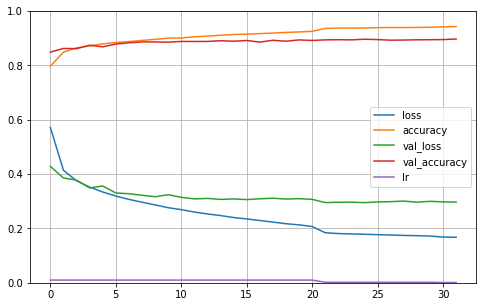

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=[8,5])
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)

In [9]:
model.evaluate(x_test_scaler, y_test, verbose=2)

10000/1 - 1s - loss: 0.2321 - accuracy: 0.8871


[0.32719144454598426, 0.8871]

In [11]:
%load_ext tensorboard
%tensorboard --logdir data/callbacks

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [12]:
from tensorboard import notebook
notebook.list() 

Known TensorBoard instances:
  - port 6007: logdir data/callbacks (started 0:01:24 ago; pid 5513)
  - port 6006: logdir ./data/keras_model (started 0:04:06 ago; pid 5473)


In [13]:
#在tensorboard中查看模型
notebook.start("--logdir ./data/callbacks")